#### Basic Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import pickle
import requests
import os
from bs4 import BeautifulSoup
import time, random


#### Scikit Learn and NLP imports

In [319]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/archana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/archana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/archana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Deep learning imports

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Conv1D, MaxPool2D, MaxPool1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

### Data Collection
Load the pickle file saved at the end of GetBookId notebook which is where all data collection is done.

In [173]:
with open('data/books_df_clean.pkl', 'rb') as f:
    books_df = pickle.load(f)

### Data Understanding

In [174]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10366 entries, 0 to 10365
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          10366 non-null  object
 1   BookId         10366 non-null  object
 2   Author         10366 non-null  object
 3   PublishedDate  7637 non-null   object
 4   Genre          8876 non-null   object
 5   Summary        10366 non-null  object
 6   NewGenre       10366 non-null  object
 7   Fiction        10366 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 648.0+ KB


In [175]:
books_df['NewGenre'] = np.where(books_df['NewGenre'] == '', np.nan, books_df['NewGenre'])
books_df.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    2729
Genre            1490
Summary             0
NewGenre         3270
Fiction             0
dtype: int64

In [176]:
books_df_clean = books_df.dropna(subset=['NewGenre'])
books_df_clean.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    1696
Genre             673
Summary             0
NewGenre            0
Fiction             0
dtype: int64

In [177]:
books_df_clean['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     636
romance        545
thriller       491
humor          458
horror         398
philosophy     228
crime          133
science         78
roman           37
comedy           8
Name: count, dtype: int64

#### We can see that 'roman' genre was retained even though it was not in the main genres list. This is due to 'romance' containing substring 'roman' . We can remove some of the under represented genres. It is a unbalanced dataset.

In [178]:
books_df_clean['Fiction'].value_counts()

Fiction
1    6845
0     251
Name: count, dtype: int64

#### This is a heavily unbalance dataset between fiction and non-fiction. We will not deal with this as we are only concerned with fiction genres.

In [179]:
document = books_df_clean['Summary'].iloc[0]
document

' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, Beasts of England. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. Napol

#### The `Summary`  contains many stopwords and punctuations, need to clean it up. We will look at some visualization after we clean it up.

### Data Preparation and Further Data Understanding

#### Remove non-fiction genre

In [180]:
books_df_clean_ext = books_df_clean.copy()
books_df_clean_ext = books_df_clean_ext[books_df_clean_ext['Fiction'] == 1]
books_df_clean_ext.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6845 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          6845 non-null   object
 1   BookId         6845 non-null   object
 2   Author         6845 non-null   object
 3   PublishedDate  5217 non-null   object
 4   Genre          6267 non-null   object
 5   Summary        6845 non-null   object
 6   NewGenre       6845 non-null   object
 7   Fiction        6845 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 481.3+ KB


In [181]:
books_df_clean_ext['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     621
romance        542
thriller       488
humor          431
horror         397
philosophy     121
crime          115
roman           36
comedy           7
science          3
Name: count, dtype: int64

#### Removing 'comedy' and 'roman' and 'science' genres due to low representation and remove 'philosophy' as it is not main fiction genre. Removing 'crime' as well because it can be classified as 'thriller' or 'mystery' as well

In [182]:
main_genres = ['fantasy','mystery','historical','romance','thriller','humor','horror']
books_df_clean_ext = books_df_clean_ext[books_df_clean_ext['NewGenre'].isin(main_genres)]
books_df_clean_ext['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     621
romance        542
thriller       488
humor          431
horror         397
Name: count, dtype: int64

In [183]:
le = LabelEncoder()
books_df_clean_ext['GenreNum'] = le.fit_transform(books_df_clean_ext['NewGenre'])
books_df_clean_ext['CollectiveSummary'] = books_df_clean_ext['Title'] + " " + books_df_clean_ext['Summary']

In [184]:
def clean_summary(text):
    word_tokens = word_tokenize(text)
    stopwords_punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    all_stop_words = stopwords_punct.union(stop_words)
    all_stop_words = all_stop_words.union(set(["''", "``"]))
    filtered_tokens = [w for w in word_tokens if not w.lower() in all_stop_words]
    return ' '.join([w for w in filtered_tokens])

books_df_clean_ext['CleanSummary'] = books_df_clean_ext['CollectiveSummary'].apply(clean_summary)
books_df_clean_ext

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction,GenreNum,CollectiveSummary,CleanSummary
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1,0,"Animal Farm Old Major, the old boar on the Ma...",Animal Farm Old Major old boar Manor Farm call...
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1,2,"A Clockwork Orange Alex, a teenager living in...",Clockwork Orange Alex teenager living near-fut...
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1,0,A Fire Upon the Deep The novel posits that sp...,Fire Upon Deep novel posits space around Milky...
5,All Quiet on the Western Front,355697,Erich Maria Remarque,1929-01-29,War novel Roman à clef,"The book tells the story of Paul Bäumer, a Ge...",historical,1,1,All Quiet on the Western Front The book tells...,Quiet Western Front book tells story Paul Bäum...
6,A Wizard of Earthsea,13642,Ursula K. Le Guin,1968,Children's literature Fantasy Speculative fict...,"Ged is a young boy on Gont, one of the larger...",fantasy,1,0,A Wizard of Earthsea Ged is a young boy on Go...,Wizard Earthsea Ged young boy Gont one larger ...
...,...,...,...,...,...,...,...,...,...,...,...
10357,Shelter,13595638,Harlan Coben,2011-09-15,NaN,"After Mickey Bolitar moves in with his uncle,...",mystery,1,4,Shelter After Mickey Bolitar moves in with hi...,Shelter Mickey Bolitar moves uncle Myron Bolit...
10358,The Third Lynx,529644,Timothy Zahn,2007,Science Fiction,The story starts with former government agent...,mystery,1,4,The Third Lynx The story starts with former g...,Third Lynx story starts former government agen...
10360,Remote Control,601621,Andy McNab,1997,Thriller Fiction Suspense,The series follows the character of Nick Ston...,thriller,1,6,Remote Control The series follows the charact...,Remote Control series follows character Nick S...
10363,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",fantasy,1,0,"Under Wildwood Prue McKeel, having rescued he...",Wildwood Prue McKeel rescued brother Dowager G...


In [185]:
books_df_clean_ext.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6563 entries, 0 to 10364
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title              6563 non-null   object
 1   BookId             6563 non-null   object
 2   Author             6563 non-null   object
 3   PublishedDate      5011 non-null   object
 4   Genre              6056 non-null   object
 5   Summary            6563 non-null   object
 6   NewGenre           6563 non-null   object
 7   Fiction            6563 non-null   int64 
 8   GenreNum           6563 non-null   int64 
 9   CollectiveSummary  6563 non-null   object
 10  CleanSummary       6563 non-null   object
dtypes: int64(2), object(9)
memory usage: 615.3+ KB


#### Lets  visualize with word clouds what words are prominent in two different genres

In [186]:
books_df_fantasy = books_df_clean_ext[books_df_clean_ext['NewGenre'] == 'fantasy']
books_df_mystery = books_df_clean_ext[books_df_clean_ext['NewGenre'] == 'mystery']


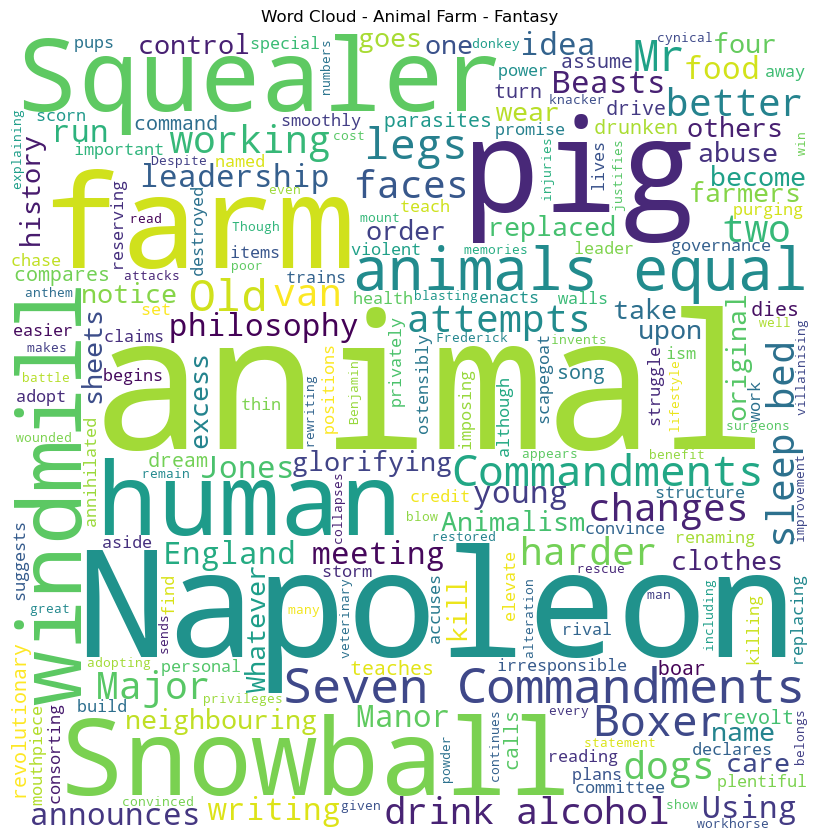

In [187]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummary'].iloc[0])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[0]+' - Fantasy')
plt.show()


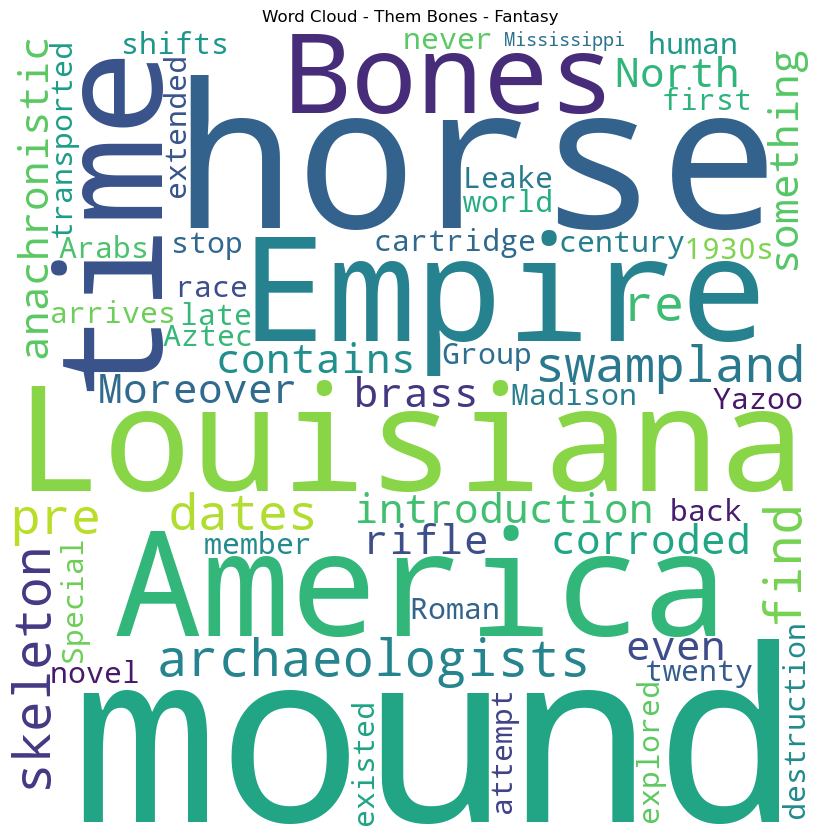

In [188]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummary'].iloc[1000])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[1000]+' - Fantasy')
plt.show()

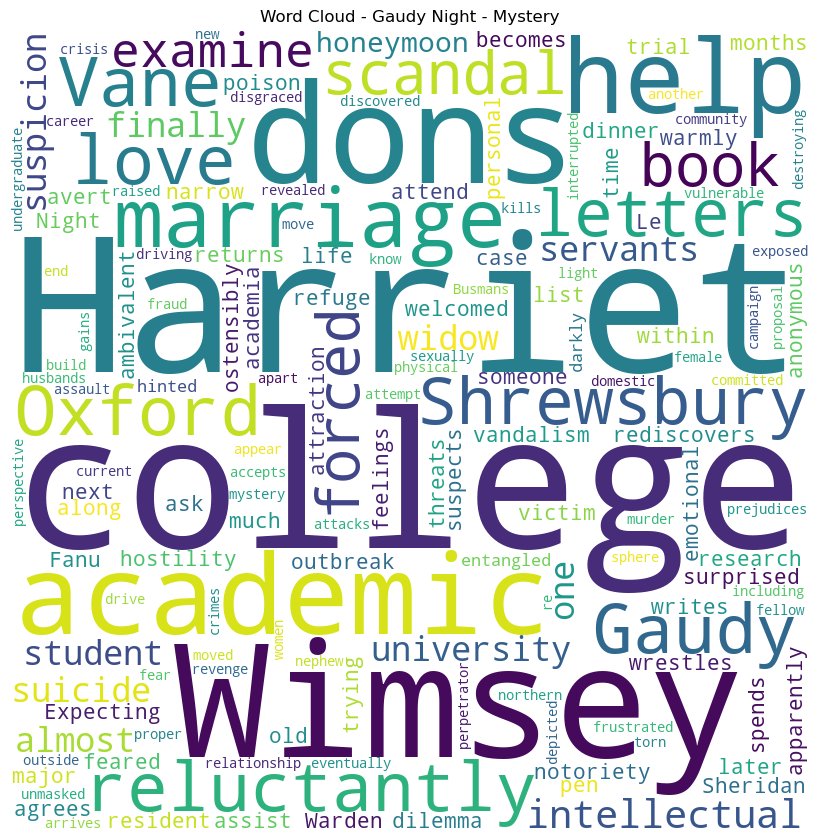

In [189]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_mystery['CleanSummary'].iloc[0])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_mystery['Title'].iloc[0]+' - Mystery')
plt.show()

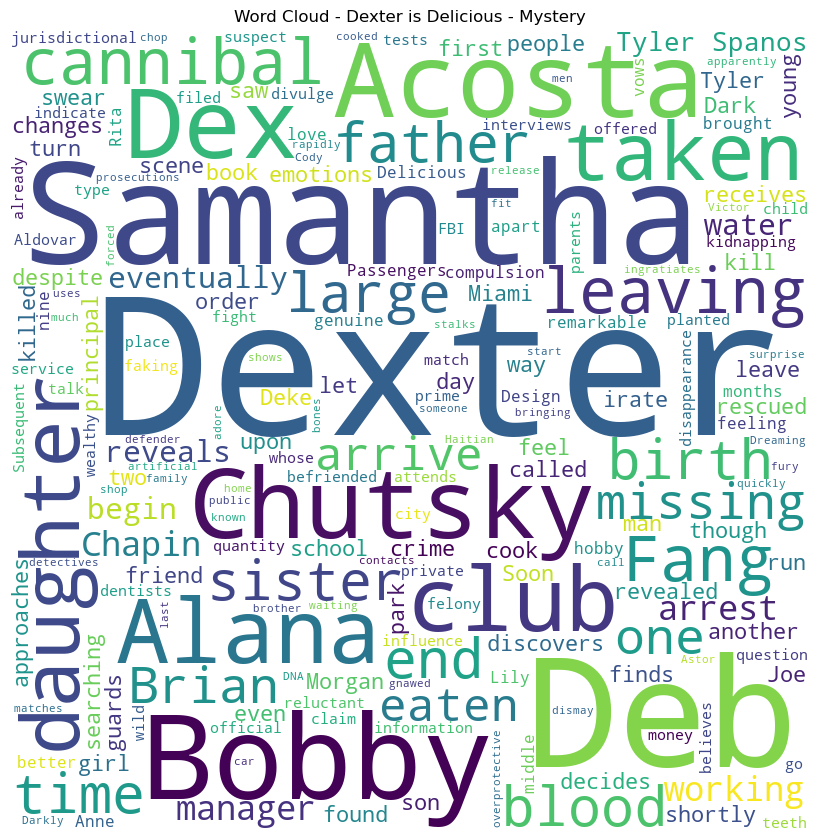

In [190]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_mystery['CleanSummary'].iloc[1000])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_mystery['Title'].iloc[1000]+' - Mystery')
plt.show()

#### There are many named entities especially person names that are very prominent across all summaries above. Nothing else really stands out.

In [191]:
'''from collections import Counter
cnt = Counter()

for word in filtered_tokens:
    cnt[word] += 1

cnt.most_common()
word_freq = pd.DataFrame(cnt.most_common(20),
                             columns=['words', 'count'])
word_freq.head()
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")
ax.set_title("Common Words Found")
plt.show()'''

'from collections import Counter\ncnt = Counter()\n\nfor word in filtered_tokens:\n    cnt[word] += 1\n\ncnt.most_common()\nword_freq = pd.DataFrame(cnt.most_common(20),\n                             columns=[\'words\', \'count\'])\nword_freq.head()\nfig, ax = plt.subplots(figsize=(12, 8))\n\n# Plot horizontal bar graph\nword_freq.sort_values(by=\'count\').plot.barh(x=\'words\',\n                      y=\'count\',\n                      ax=ax,\n                      color="brown")\nax.set_title("Common Words Found")\nplt.show()'

#### Visualizing length of clean summary across books

In [192]:
#Length of Summary for books
summary_lengths = [len(word_tokenize(s)) for s in books_df_clean_ext['CleanSummary']]
summary = range(0, books_df_clean_ext.shape[0])
summary_df = pd.DataFrame({'summary_length':summary_lengths})


Text(0.5, 1.0, 'Summary Length Across Books')

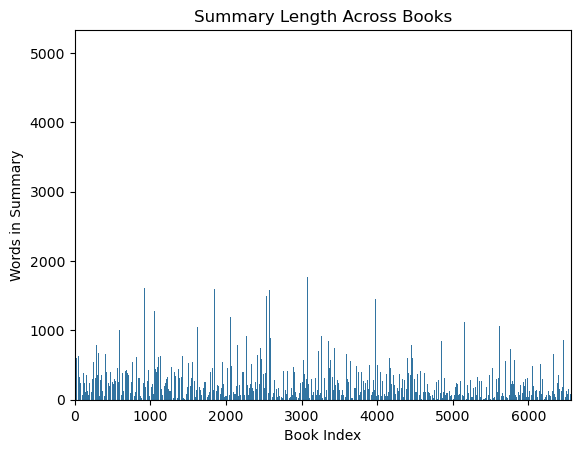

In [193]:
sns.barplot(data=summary_df, x=summary_df.index, y='summary_length')
plt.xticks(np.arange(0, books_df_clean_ext.shape[0], 1000));
plt.xlabel('Book Index')
plt.ylabel('Words in Summary')
plt.title('Summary Length Across Books')

#### There are some outliers but most of the them are under 1000 words.

#### Extract named entities and create a new column

In [194]:
#Named entities in summary
def get_named_entities(text):
    word_tokens = word_tokenize(text)
    pos_tokens = nltk.pos_tag(word_tokens)
    tree = nltk.ne_chunk(pos_tokens)
    named_entities = []
    for word in tree:
        if hasattr(word, 'label'):
            named_entities.append((' '.join(c[0] for c in word.leaves()), word.label()))
    return named_entities
books_df_clean_ext['NamedEntities'] = books_df_clean_ext['CleanSummary'].apply(get_named_entities)
books_df_clean_ext

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction,GenreNum,CollectiveSummary,CleanSummary,NamedEntities
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1,0,"Animal Farm Old Major, the old boar on the Ma...",Animal Farm Old Major old boar Manor Farm call...,"[(Animal, PERSON), (Farm Old, ORGANIZATION), (..."
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1,2,"A Clockwork Orange Alex, a teenager living in...",Clockwork Orange Alex teenager living near-fut...,"[(Clockwork, PERSON), (Orange Alex, PERSON), (..."
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1,0,A Fire Upon the Deep The novel posits that sp...,Fire Upon Deep novel posits space around Milky...,"[(Fire, PERSON), (Upon Deep, PERSON), (Milky W..."
5,All Quiet on the Western Front,355697,Erich Maria Remarque,1929-01-29,War novel Roman à clef,"The book tells the story of Paul Bäumer, a Ge...",historical,1,1,All Quiet on the Western Front The book tells...,Quiet Western Front book tells story Paul Bäum...,"[(Quiet, GPE), (Western Front, LOCATION), (Pau..."
6,A Wizard of Earthsea,13642,Ursula K. Le Guin,1968,Children's literature Fantasy Speculative fict...,"Ged is a young boy on Gont, one of the larger...",fantasy,1,0,A Wizard of Earthsea Ged is a young boy on Go...,Wizard Earthsea Ged young boy Gont one larger ...,"[(Wizard, PERSON), (Earthsea Ged, PERSON), (Ea..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10357,Shelter,13595638,Harlan Coben,2011-09-15,NaN,"After Mickey Bolitar moves in with his uncle,...",mystery,1,4,Shelter After Mickey Bolitar moves in with hi...,Shelter Mickey Bolitar moves uncle Myron Bolit...,"[(Shelter, PERSON), (Mickey Bolitar, PERSON), ..."
10358,The Third Lynx,529644,Timothy Zahn,2007,Science Fiction,The story starts with former government agent...,mystery,1,4,The Third Lynx The story starts with former g...,Third Lynx story starts former government agen...,"[(Third, PERSON), (Lynx, ORGANIZATION), (Frank..."
10360,Remote Control,601621,Andy McNab,1997,Thriller Fiction Suspense,The series follows the character of Nick Ston...,thriller,1,6,Remote Control The series follows the charact...,Remote Control series follows character Nick S...,"[(Remote, PERSON), (Control, ORGANIZATION), (N..."
10363,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",fantasy,1,0,"Under Wildwood Prue McKeel, having rescued he...",Wildwood Prue McKeel rescued brother Dowager G...,"[(Wildwood, PERSON), (Prue, ORGANIZATION), (Do..."


In [195]:
entities_length = [len(e) for e in books_df_clean_ext['NamedEntities']]
books = range(0, books_df_clean_ext.shape[0])
entity_df = pd.DataFrame({'entities_length':entities_length})

Text(0.5, 1.0, 'Named Entities Across Books')

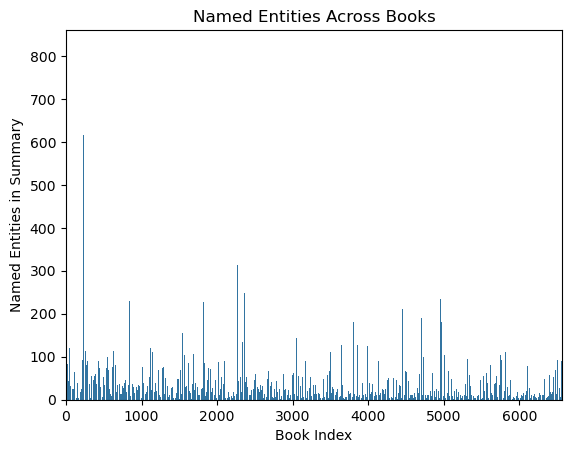

In [196]:
sns.barplot(data=entity_df, x=entity_df.index, y='entities_length')
plt.xticks(np.arange(0, books_df_clean_ext.shape[0], 1000));
plt.xlabel('Book Index')
plt.ylabel('Named Entities in Summary')
plt.title('Named Entities Across Books')

#### Number of named entities is also all over the range but around 50-100 for most. We can use the dataframe as is for modeling first and see what results we get. As a next step, we can remove all named entities, lemmatize/stem the remaining words and try modeling.

In [197]:
books_df_clean_ext['NamedEntities'].iloc[0]

[('Animal', 'PERSON'),
 ('Farm Old', 'ORGANIZATION'),
 ('Manor Farm', 'PERSON'),
 ('England Major', 'PERSON'),
 ('Snowball Napoleon', 'ORGANIZATION'),
 ('Jones', 'PERSON'),
 ('Animal Farm', 'PERSON'),
 ('Seven Commandments', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Napoleon Snowball', 'PERSON'),
 ('Snowball', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Squealer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Napoleon Squealer', 'PERSON'),
 ('Snowball', 'PERSON'),
 ('Snowball', 'ORGANIZATION'),
 ('Napoleon', 'ORGANIZATION'),
 ('Napoleon Squealer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Seven Commandments Animalism', 'PERSON'),
 ('England', 'GPE'),
 ('Napoleon', 'PERSON'),
 ('Jones Squealer', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Benjamin', 'PERSON'),
 ('Seven Commandments', 'ORGANIZATION'),
 ('Napoleon', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Manor Farm', 'PERSON'),
 ('Napoleon Mr Pilkington', 'PERSON'),
 ('Snowball Napoleon Squealer'

In [198]:
books_df_clean_ext['NamedEntities'].iloc[1]

[('Clockwork', 'PERSON'),
 ('Orange Alex', 'PERSON'),
 ('England', 'GPE'),
 ('Nadsat Dim', 'PERSON'),
 ('Georgie', 'PERSON'),
 ('Pete', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Beethoven Lovely Ludwig Van', 'PERSON'),
 ('Korova Milkbar', 'PERSON'),
 ('Clockwork Orange Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Dim', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Georgie', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Dims', 'PERSON'),
 ('Georgie', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Georgies', 'PERSON'),
 ('Alexs', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alexs Bible', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Scripture', 'PERSON'),
 ('Alexs', 'PERSON'),
 ('Ludovico Technique', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Fifth', 'PERSON'),
 ('Alex', 'PERSON'),
 ('VIPs', 'ORGANIZATION'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alexs', 'PERSON'),
 ('Alex', 'PERSON'),
 (

#### Removing all 'PERSON' entities

In [199]:
def removePersonEntities(text, named_entities):
    for tup in named_entities:
        if tup[-1] == 'PERSON':
            text = text.replace(tup[0], "")
    return text

#removePersonEntities(books_df_clean_ext['CleanSummary'].iloc[0], books_df_clean_ext['NamedEntities'].iloc[0])
books_df_clean_ext['CleanSummaryNoPerson'] = books_df_clean_ext.apply(lambda x: removePersonEntities(x.CleanSummary, x.NamedEntities), axis=1)

    

In [200]:
books_df_clean_ext['NamedEntities'].iloc[0]

[('Animal', 'PERSON'),
 ('Farm Old', 'ORGANIZATION'),
 ('Manor Farm', 'PERSON'),
 ('England Major', 'PERSON'),
 ('Snowball Napoleon', 'ORGANIZATION'),
 ('Jones', 'PERSON'),
 ('Animal Farm', 'PERSON'),
 ('Seven Commandments', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Napoleon Snowball', 'PERSON'),
 ('Snowball', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Squealer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Napoleon Squealer', 'PERSON'),
 ('Snowball', 'PERSON'),
 ('Snowball', 'ORGANIZATION'),
 ('Napoleon', 'ORGANIZATION'),
 ('Napoleon Squealer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Seven Commandments Animalism', 'PERSON'),
 ('England', 'GPE'),
 ('Napoleon', 'PERSON'),
 ('Jones Squealer', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Boxer', 'PERSON'),
 ('Benjamin', 'PERSON'),
 ('Seven Commandments', 'ORGANIZATION'),
 ('Napoleon', 'PERSON'),
 ('Napoleon', 'PERSON'),
 ('Manor Farm', 'PERSON'),
 ('Napoleon Mr Pilkington', 'PERSON'),
 ('Snowball Napoleon Squealer'

In [201]:
books_df_clean_ext['CleanSummaryNoPerson'].iloc[0]

' Farm Old Major old boar  calls animals farm meeting compares humans parasites teaches animals revolutionary song Beasts  dies two young pigs   assume command turn dream philosophy animals revolt drive drunken irresponsible Mr  farm renaming  Farm adopt  -ism important animals equal  attempts teach animals reading writing food plentiful farm runs smoothly pigs elevate positions leadership set aside special food items ostensibly personal health  takes pups farm dogs trains privately   struggle leadership  announces plans build windmill  dogs chase  away declares leader  enacts changes governance structure farm replacing meetings committee pigs run farm Using young pig named  mouthpiece  claims credit windmill idea animals work harder promise easier lives windmill violent storm animals find windmill annihilated   convince animals  destroyed although scorn neighbouring farmers suggests walls thin  becomes scapegoat  begins purging farm dogs killing animals accuses consorting old rival pi

In [202]:
books_df_fantasy = books_df_clean_ext[books_df_clean_ext['NewGenre'] == 'fantasy']

In [203]:
books_df_fantasy['NamedEntities'].iloc[1000]

[('Louisiana', 'PERSON'),
 ('North America', 'LOCATION'),
 ('Madison Yazoo Leake', 'PERSON'),
 ('Special Group', 'ORGANIZATION'),
 ('Arabs', 'PERSON'),
 ('America Roman Empire', 'ORGANIZATION'),
 ('Aztec', 'PERSON'),
 ('Mississippi', 'PERSON')]

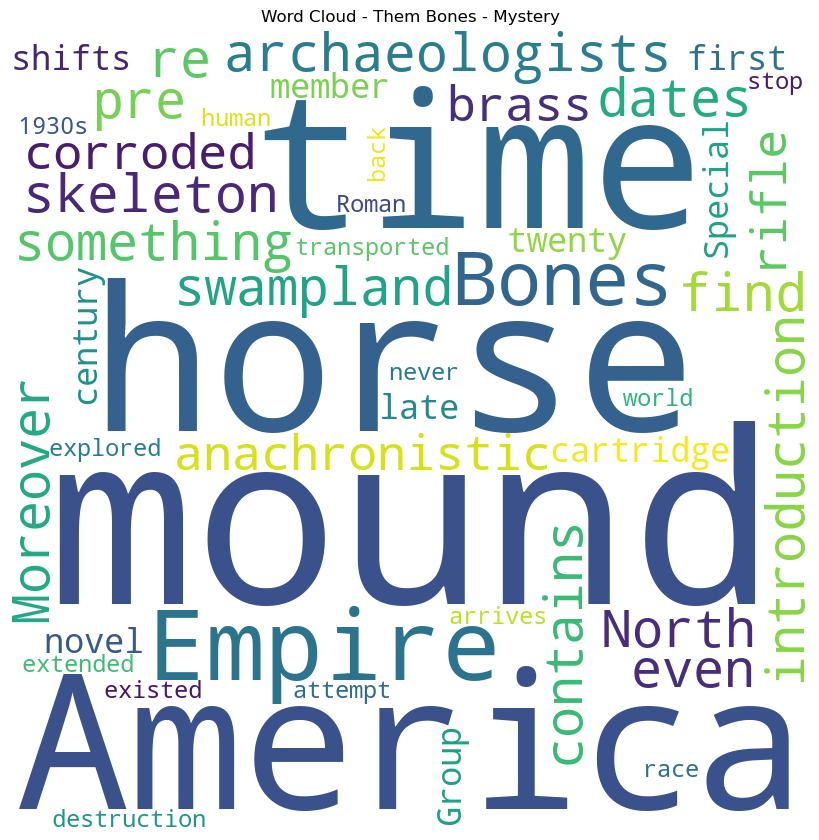

In [204]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummaryNoPerson'].iloc[1000])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[1000]+' - Mystery')
plt.show()

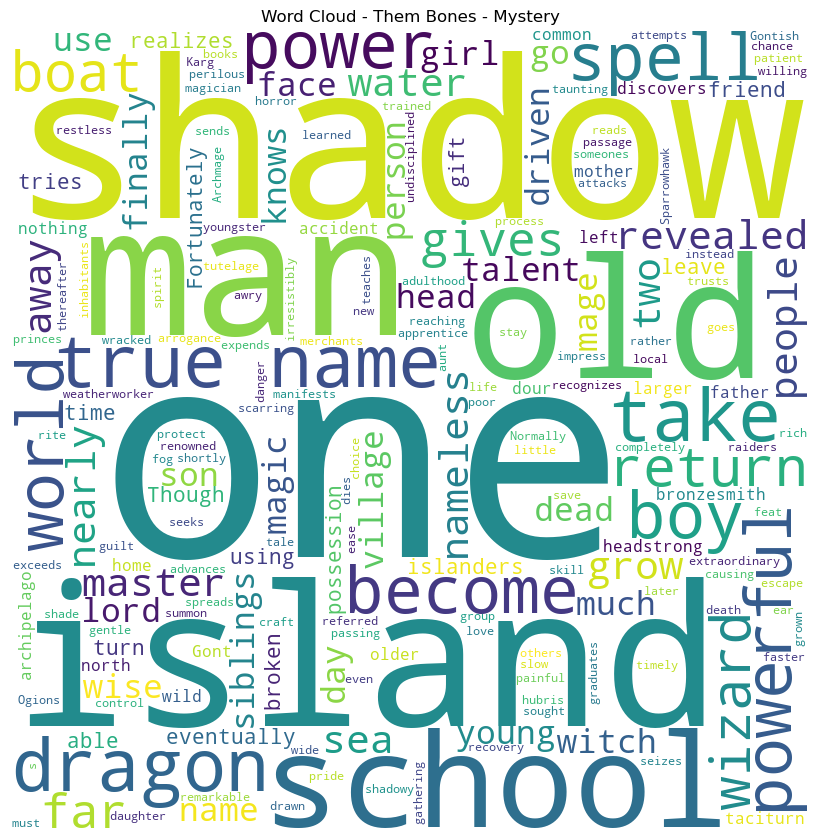

In [205]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummaryNoPerson'].iloc[2])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[1000]+' - Mystery')
plt.show()

### Modeling

#### Modeling with `CleanSummary` with named entities

In [280]:
books_df_shuffled = shuffle(books_df_clean_ext, random_state=5)
X = books_df_shuffled[['CleanSummary']]
y = books_df_shuffled['GenreNum']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6563, 1) (6563,)
(4922, 1) (4922,) (1641, 1) (1641,)


In [281]:
y.value_counts()

GenreNum
0    2930
4    1154
1     621
5     542
6     488
3     431
2     397
Name: count, dtype: int64

#### Using TFIDF and LogisticRegression with no hyperparameter tuning

In [282]:
tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze())
X_test_vec = tfidf_vec.transform(X_test.squeeze())
lgr_tfidf = LogisticRegression(fit_intercept=True, max_iter=800)
lgr_tfidf.fit(X_train_vec, y_train.squeeze())

LogisticRegression(max_iter=800)

In [283]:
y_predict_train = lgr_tfidf.predict(X_train_vec)
score = accuracy_score(y_train.squeeze(), y_predict_train)
print("Train accuracy score:"+str(score))
y_predict_test = lgr_tfidf.predict(X_test_vec)
score = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test accuracy score:"+str(score))

Train accuracy score:0.8104429093864283
Test accuracy score:0.6319317489335771


#### Using Naive Bayes with hyperparam tuning 

In [284]:
bayes_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('bayes', MultinomialNB())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'bayes__alpha':[1,3,5]}
bayes_tfidf_grid = GridSearchCV(estimator= bayes_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
start = time.time()
bayes_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start

In [285]:
y_predict_train = bayes_tfidf_grid.best_estimator_.predict(X_train.squeeze())
nb_withNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Train accuracy score:"+str(nb_withNE_trainscore))
y_predict_test = bayes_tfidf_grid.best_estimator_.predict(X_test.squeeze())
nb_withNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test accuracy score:"+str(nb_withNE_testscore))
nb_tuning_withNE_fittime = end
print("Fit Time:",end)

Train accuracy score:0.650954896383584
Test accuracy score:0.6130408287629494
Fit Time: 59.12119960784912


#### Using Logistic Regression with hyperparam tuning

In [286]:
lgr_ltd_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('lgr', LogisticRegression(max_iter=5000))])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'lgr__C':[1,2,4,5,10,100]}
lgr_ltd_tfidf_grid = GridSearchCV(estimator= lgr_ltd_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
start = time.time()
lgr_ltd_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start

In [287]:
y_predict_train = lgr_ltd_tfidf_grid.best_estimator_.predict(X_train.squeeze())
lgr_withNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:",lgr_withNE_trainscore)
y_predict_test = lgr_ltd_tfidf_grid.best_estimator_.predict(X_test.squeeze())
lgr_withNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:",lgr_withNE_testscore)
lgr_tuning_withNE_fittime = end
print("Fit Time:",end)

Training Accuracy: 0.866111336854937
Test Accuracy: 0.6819012797074955
Fit Time: 152.72052526474


#### Using Decision Tree with hyperparam tuning

In [288]:
dtree_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('dtree', DecisionTreeClassifier())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'dtree__max_depth': [10, 20, 30, None], 
         'dtree__min_samples_split': [2, 5, 10],
        'dtree__min_samples_leaf': [1, 2, 4]}

dtree_tfidf_grid = HalvingRandomSearchCV(estimator= dtree_tfidf_pipe, cv=5, scoring='accuracy', param_distributions=params)
start = time.time()
dtree_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start
y_predict_train = dtree_tfidf_grid.best_estimator_.predict(X_train.squeeze())
dtree_withNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:",dtree_withNE_trainscore)
y_predict_test = dtree_tfidf_grid.best_estimator_.predict(X_test.squeeze())
dtree_withNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:",dtree_withNE_testscore)
dtree_tuning_withNE_fittime = end
print("Fit Time:",end)

Training Accuracy: 0.585737505079236
Test Accuracy: 0.5155393053016454
Fit Time: 23.294064044952393


#### Using SVM with hyperparam tuning

In [289]:
svc_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('svc', SVC())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None],
         'svc__C': [0.1, 1, 10, 100, 1000],  
         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
         'svc__kernel': ['rbf']}
svc_tfidf_grid = HalvingRandomSearchCV(estimator= svc_tfidf_pipe, cv=5, scoring='accuracy', param_distributions=params)
start = time.time()
svc_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start
y_predict_train = svc_tfidf_grid.best_estimator_.predict(X_train.squeeze())
svm_withNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:",svm_withNE_trainscore)
y_predict_test = svc_tfidf_grid.best_estimator_.predict(X_test.squeeze())
svm_withNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:",svm_withNE_testscore)
svm_tuning_withNE_fittime = end
print("Fit Time:",end)

Training Accuracy: 0.9368143031288094
Test Accuracy: 0.6654478976234004
Fit Time: 87.62904071807861


#### Using KNN

In [290]:
knn_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('knn', KNeighborsClassifier())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None],
         'knn__n_neighbors': [2,5,10,20,30,100]}
knn_tfidf_grid = GridSearchCV(estimator= knn_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
start = time.time()
knn_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start
y_predict_train = knn_tfidf_grid.best_estimator_.predict(X_train.squeeze())
knn_withNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:",knn_withNE_trainscore)
y_predict_test = knn_tfidf_grid.best_estimator_.predict(X_test.squeeze())
knn_withNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:",knn_withNE_testscore)
knn_tuning_withNE_fittime = end
print("Fit Time:",end)

Training Accuracy: 0.5782202356765542
Test Accuracy: 0.5636806825106643
Fit Time: 146.4738576412201


In [291]:
results_withNE = pd.DataFrame({"models" : ['NaiveBayes','LogisticRegression', 'DecisionTree', 'SVC', 'KNN'],
                              "Train Score" : [nb_withNE_trainscore, lgr_withNE_trainscore, dtree_withNE_trainscore,svm_withNE_trainscore,knn_withNE_trainscore],
                               "Test Score" : [nb_withNE_testscore, lgr_withNE_testscore, dtree_withNE_testscore, svm_withNE_testscore, knn_withNE_testscore],
                               "Fit Time" : [nb_tuning_withNE_fittime, lgr_tuning_withNE_fittime, dtree_tuning_withNE_fittime, svm_tuning_withNE_fittime,knn_tuning_withNE_fittime]})                              
results_withNE

,models,Train Score,Test Score,Fit Time
0,NaiveBayes,0.650955,0.613041,59.121200
1,LogisticRegression,0.866111,0.681901,152.720525
2,DecisionTree,0.585738,0.515539,23.294064
3,SVC,0.936814,0.665448,87.629041
4,KNN,0.578220,0.563681,146.473858


#### Logistic Regression and SVC have better performance overall. Will use these two models going further and pick one of them.

#### Modeling with CleanSummaryNoPerson

In [296]:
books_df_shuffled_noNE = shuffle(books_df_clean_ext, random_state=5)
X = books_df_shuffled_noNE[['CleanSummaryNoPerson']]
y = books_df_shuffled_noNE['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

#### LogisticRegression with Hyperparam tuning

In [297]:
lgr_ltd_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('lgr', LogisticRegression(max_iter=5000))])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'lgr__C':[1,2,4,5,10,100]}
lgr_ltd_tfidf_grid = GridSearchCV(estimator= lgr_ltd_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
start = time.time()
lgr_ltd_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start
y_predict_train = lgr_ltd_tfidf_grid.best_estimator_.predict(X_train.squeeze())
lgr_noNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Score:" ,lgr_noNE_trainscore)
y_predict_test = lgr_ltd_tfidf_grid.best_estimator_.predict(X_test.squeeze())
lgr_noNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Score:", lgr_noNE_testscore)
lgr_tuning_noNE_fittime = end
print("Fit Time:",end)

Training Score: 0.8598130841121495
Test Score: 0.6751980499695308
Fit Time: 139.0685293674469


#### SVM with hyperparam tuning

In [298]:
svc_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('svc', SVC())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None],
         'svc__C': [0.1, 1, 10, 100, 1000],  
         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
         'svc__kernel': ['rbf']}
svc_tfidf_grid = HalvingRandomSearchCV(estimator= svc_tfidf_pipe, cv=5, scoring='accuracy', param_distributions=params)
start = time.time()
svc_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())
end = time.time() - start
y_predict_train = svc_tfidf_grid.best_estimator_.predict(X_train.squeeze())
svm_noNE_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:",svm_noNE_trainscore)
y_predict_test = svc_tfidf_grid.best_estimator_.predict(X_test.squeeze())
svm_noNE_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:",svm_noNE_testscore)
svm_tuning_noNE_fittime = end
print("Fit Time:",end)

Training Accuracy: 0.9995936611133686
Test Accuracy: 0.6197440585009141
Fit Time: 77.14529514312744


In [300]:
results_noNE = pd.DataFrame({"models" : ['LogisticRegression','SVC'],
                              "Train Score" : [lgr_noNE_trainscore, svm_noNE_trainscore],
                               "Test Score" : [lgr_noNE_testscore, svm_noNE_testscore],
                               "Fit Time" : [lgr_tuning_noNE_fittime, svm_tuning_noNE_fittime]})                              
results_noNE

,models,Train Score,Test Score,Fit Time
0,LogisticRegression,0.859813,0.675198,139.068529
1,SVC,0.999594,0.619744,77.145295


#### Logistic Regression is still performing well. SVC shows lower accuracy, this could be due to the randomized grid search. We will pick LogisticRegression to move forward.

In [303]:
lgr_final_model_grid = lgr_ltd_tfidf_grid

### Lets look at other performance metrics like confusion matrix and ROC curve.

#### Confusion matrix. 

In [301]:
genre_num_list = pd.DataFrame(books_df_shuffled_noNE['GenreNum'].value_counts()).index.tolist()
genre_name_list = pd.DataFrame(books_df_shuffled_noNE['NewGenre'].value_counts()).index.tolist()
genre_dict = {}
for idx in range(0, len(genre_num_list)):
    genre_dict.update({genre_num_list[idx] : genre_name_list[idx]})
genre_dict

{0: 'fantasy',
 4: 'mystery',
 1: 'historical',
 5: 'romance',
 6: 'thriller',
 3: 'humor',
 2: 'horror'}

In [302]:
def get_class_names(num):
    return genre_dict[num]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'fantasy'),
  Text(1, 0, 'historical'),
  Text(2, 0, 'horror'),
  Text(3, 0, 'humor'),
  Text(4, 0, 'mystery'),
  Text(5, 0, 'romance'),
  Text(6, 0, 'thriller')])

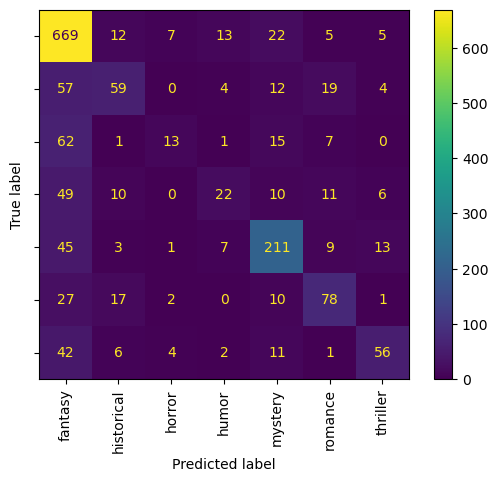

In [335]:
y_predict_test = lgr_final_model_grid.best_estimator_.predict(X_test.squeeze())
cm = confusion_matrix(y_test, y_predict_test, labels=lgr_final_model_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=map(get_class_names,lgr_final_model_grid.best_estimator_.classes_))
disp.plot()
plt.xticks(rotation=90)

In [336]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       733
           1       0.55      0.38      0.45       155
           2       0.48      0.13      0.21        99
           3       0.45      0.20      0.28       108
           4       0.73      0.73      0.73       289
           5       0.60      0.58      0.59       135
           6       0.66      0.46      0.54       122

    accuracy                           0.68      1641
   macro avg       0.59      0.49      0.51      1641
weighted avg       0.65      0.68      0.64      1641



#### The f1-score seems to be dependent on the number of training samples for each genre. Higher the sample size, higher the score. If we add more data to balance the dataset, we might get good scroes with this model.

#### ROC Curve

In [321]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train.squeeze())
y_onehot_test = label_binarizer.transform(y_test.squeeze())
y_onehot_test.shape  # (n_samples, n_classes)
y_probs = lgr_final_model_grid.best_estimator_.predict_proba(X_test.squeeze())

array([[0.3866873 , 0.03093213, 0.12090541, ..., 0.22269122, 0.06966712,
        0.03289923],
       [0.88677759, 0.04023794, 0.01495648, ..., 0.02103643, 0.00244089,
        0.01308659],
       [0.44756598, 0.08873438, 0.08799504, ..., 0.08268983, 0.07894537,
        0.13306834],
       ...,
       [0.17649656, 0.21721171, 0.07151958, ..., 0.16445979, 0.09805108,
        0.02908154],
       [0.03366817, 0.03908558, 0.01830014, ..., 0.01771738, 0.86193742,
        0.01154723],
       [0.76020727, 0.01419251, 0.04099209, ..., 0.02225845, 0.0127764 ,
        0.08291297]])

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'Micro-averaged One-vs-Rest\nReceiver Operating Characteristic')]

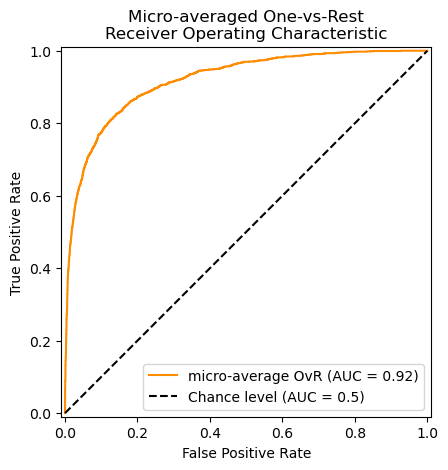

In [325]:
display = RocCurveDisplay.from_predictions(y_onehot_test.ravel(),y_probs.ravel(),name="micro-average OvR",color="darkorange",plot_chance_level=True)
display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate",title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")


In [324]:
roc_auc_score_lgr = roc_auc_score(y_test,y_probs,multi_class="ovr",average="micro")
roc_auc_score_lgr

0.9187437791223105

#### Micro average is used above as the dataset is highly imbalanced. We get a good score showing the model is a good fit. 

#### Going forward we will use accuracy, roc_auc_score and classification report to determine the better model

### Using Ensemble Techniques

In [328]:
forest_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('forest', RandomForestClassifier())])
#params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'forest__n_estimators':[1, 10, 100, 500, 1000, 2000]}
params = {'tfidf__max_features': [1000], 'tfidf__stop_words':['english'], 'forest__n_estimators':[100,500,1000,2000]}
forest_tfidf_grid = HalvingRandomSearchCV(estimator= forest_tfidf_pipe, cv=5, scoring='accuracy', param_distributions=params)
forest_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())


/home/archana/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=70. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                                ('forest',
                                                 RandomForestClassifier())]),
                      param_distributions={'forest__n_estimators': [100, 500,
                                                                    1000,
                                                                    2000],
                                           'tfidf__max_features': [1000],
                                           'tfidf__stop_words': ['english']},
                      scoring='accuracy')

In [330]:
y_predict_train = forest_tfidf_grid.best_estimator_.predict(X_train.squeeze())
forest_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Train Accuracy: ", forest_trainscore)
y_predict_test = forest_tfidf_grid.best_estimator_.predict(X_test.squeeze())
forest_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy: ", forest_testscore)

Train Accuracy:  0.9995936611133686
Test Accuracy:  0.599024984765387


In [331]:
y_probs_forest = forest_tfidf_grid.best_estimator_.predict_proba(X_test.squeeze())
roc_auc_score_forest= roc_auc_score(y_test,y_probs_forest,multi_class="ovr",average="micro")
roc_auc_score_forest

0.8876539661425811

In [337]:
y_predict_test_forest = forest_tfidf_grid.best_estimator_.predict(X_test.squeeze())
print(classification_report(y_test, y_predict_test_forest, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.58      0.95      0.72       733
           1       0.39      0.05      0.08       155
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00       108
           4       0.66      0.73      0.69       289
           5       0.59      0.37      0.45       135
           6       0.83      0.16      0.26       122

    accuracy                           0.60      1641
   macro avg       0.44      0.32      0.32      1641
weighted avg       0.52      0.60      0.51      1641



#### Overall, all the above performance metrics are below what we saw with LogisticRegression.

In [343]:
params = {'ada__estimator__C': [.001, 0.01, 0.1, 1.0, 10.0]}
adaboost_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('ada', AdaBoostClassifier(estimator = LogisticRegression(max_iter=5000), 
                                       algorithm='SAMME',random_state = 42))])
adaboost_tfidf_grid = HalvingRandomSearchCV(adaboost_tfidf_pipe,param_distributions=params, cv=5, scoring='accuracy')
adaboost_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())

/home/archana/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=70. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                                ('ada',
                                                 AdaBoostClassifier(algorithm='SAMME',
                                                                    estimator=LogisticRegression(max_iter=5000),
                                                                    random_state=42))]),
                      param_distributions={'ada__estimator__C': [0.001, 0.01,
                                                                 0.1, 1.0,
                                                                 10.0]},
                      scoring='accuracy')

In [345]:
y_predict_train = adaboost_tfidf_grid.best_estimator_.predict(X_train.squeeze())
ada_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy :" , ada_trainscore)
y_predict_test = adaboost_tfidf_grid.best_estimator_.predict(X_test.squeeze())
ada_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy : ", ada_testscore)

Training Accuracy : 0.45449004469727755
Test Accuracy :  0.45521023765996343


In [346]:
y_probs_ada = adaboost_tfidf_grid.best_estimator_.predict_proba(X_test.squeeze())
roc_auc_score_ada= roc_auc_score(y_test,y_probs_ada,multi_class="ovr",average="micro")
roc_auc_score_ada

0.7683483476123403

In [347]:
y_predict_test_ada = adaboost_tfidf_grid.best_estimator_.predict(X_test.squeeze())
print(classification_report(y_test, y_predict_test_ada, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62       733
           1       0.00      0.00      0.00       155
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00       108
           4       0.88      0.05      0.09       289
           5       0.00      0.00      0.00       135
           6       0.00      0.00      0.00       122

    accuracy                           0.46      1641
   macro avg       0.19      0.15      0.10      1641
weighted avg       0.36      0.46      0.29      1641



#### Not good overall. 

In [ ]:
params = {'gradboost__n_estimators': [50, 100, 200],'gradboost__learning_rate': [0.01, 0.1, 0.2],'gradboost__max_depth': [3, 5, 7]}
gradboost_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('gradboost', GradientBoostingClassifier(random_state = 42))])
gradboost_tfidf_grid = HalvingRandomSearchCV(gradboost_tfidf_pipe,param_distributions=params, cv=5, scoring='accuracy')
gradboost_tfidf_grid.fit(X_train.squeeze(), y_train.squeeze())

/home/archana/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=70. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [131]:
y_predict_train = gradboost_tfidf_pipe.predict(X_train.squeeze())
grad_trainscore = accuracy_score(y_train.squeeze(), y_predict_train)
print("Training Accuracy:", grad_trainscore)
y_predict_test = gradboost_tfidf_pipe.predict(X_test.squeeze())
grad_testscore = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test Accuracy:" , grad_testscore)

0.8501666993528143
0.5911764705882353


In [ ]:
y_probs_grad = adaboost_tfidf_grid.best_estimator_.predict_proba(X_test.squeeze())
roc_auc_score_grad= roc_auc_score(y_test,y_probs_grad,multi_class="ovr",average="micro")
roc_auc_score_grad

In [ ]:
y_predict_test_grad = adaboost_tfidf_grid.best_estimator_.predict(X_test.squeeze())
print(classification_report(y_test, y_predict_test_grad, zero_division=0.0))

### Using Deep Learning

In [62]:
### Simple Neural Network
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummaryNoPerson']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

callback = EarlyStopping(monitor='val_accuracy', patience=3)
tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze()).toarray()
X_test_vec = tfidf_vec.transform(X_test.squeeze()).toarray()
np.random.seed(42)
simple_tf_model = keras.Sequential([Dense(32, activation='relu'),
                                   Dense(32, activation='relu'),
                                   Dense(9, activation='softmax')])
simple_tf_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = simple_tf_model.fit(X_train_vec,y_train.squeeze(), epochs=20, validation_data=(X_test_vec, y_test.squeeze()), callbacks=[callback])

Epoch 1/20
160/160 [==============================] - 1s 7ms/step - loss: 1.9061 - accuracy: 0.4204 - val_loss: 1.4842 - val_accuracy: 0.5300
Epoch 2/20
160/160 [==============================] - 1s 4ms/step - loss: 1.3487 - accuracy: 0.5620 - val_loss: 1.2940 - val_accuracy: 0.5800
Epoch 3/20
160/160 [==============================] - 1s 4ms/step - loss: 1.0291 - accuracy: 0.6733 - val_loss: 1.1869 - val_accuracy: 0.6353
Epoch 4/20
160/160 [==============================] - 1s 4ms/step - loss: 0.7639 - accuracy: 0.7870 - val_loss: 1.1400 - val_accuracy: 0.6529
Epoch 5/20
160/160 [==============================] - 1s 4ms/step - loss: 0.5090 - accuracy: 0.9014 - val_loss: 1.1345 - val_accuracy: 0.6606
Epoch 6/20
160/160 [==============================] - 1s 4ms/step - loss: 0.3313 - accuracy: 0.9359 - val_loss: 1.1889 - val_accuracy: 0.6588
Epoch 7/20
160/160 [==============================] - 1s 4ms/step - loss: 0.2085 - accuracy: 0.9424 - val_loss: 1.2780 - val_accuracy: 0.6559
Epoch 

In [38]:
X_train_vec.shape

TensorShape([5099, 1, 51248])

In [63]:
### Convoluted Neural Network
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummaryNoPerson']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

callback = EarlyStopping(monitor='val_accuracy', patience=3)
tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze()).toarray()
tf_len = len(tfidf_vec.vocabulary_)
X_train_vec.reshape(X_train_vec.shape[0], X_train_vec.shape[1],1)
X_test_vec = tfidf_vec.transform(X_test.squeeze()).toarray()
X_test_vec.reshape(X_test_vec.shape[0], X_test_vec.shape[1],1)

np.random.seed(42)
input = Input(batch_shape=(None, tf_len,1))
conv1 = Conv1D(filters=16, kernel_size=3, activation='relu')(input)
pool1 = MaxPool1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)
dense1 = Dense(50, activation='relu')(flat1)
output = Dense(9, activation='softmax')(dense1)

conv_model = Model(input, output)
conv_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['precision'])
history_conv = conv_model.fit(X_train_vec,y_train.squeeze(), epochs=20, validation_data=(X_test_vec, y_test.squeeze()), callbacks=[callback])

Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 1.8575 - accuracy: 0.4313 - val_loss: 1.3014 - val_accuracy: 0.5806
Epoch 2/20
160/160 [==============================] - 26s 164ms/step - loss: 1.0246 - accuracy: 0.6910 - val_loss: 1.1182 - val_accuracy: 0.6412
Epoch 3/20
160/160 [==============================] - 27s 167ms/step - loss: 0.4171 - accuracy: 0.8953 - val_loss: 1.0103 - val_accuracy: 0.6829
Epoch 4/20
160/160 [==============================] - 27s 168ms/step - loss: 0.1197 - accuracy: 0.9758 - val_loss: 1.2046 - val_accuracy: 0.6694
Epoch 5/20
160/160 [==============================] - 27s 167ms/step - loss: 0.0284 - accuracy: 0.9941 - val_loss: 1.4206 - val_accuracy: 0.6618
Epoch 6/20
160/160 [==============================] - 27s 167ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 1.6216 - val_accuracy: 0.6665


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'crime'),
  Text(1, 0, 'fantasy'),
  Text(2, 0, 'historical'),
  Text(3, 0, 'horror'),
  Text(4, 0, 'humor'),
  Text(5, 0, 'mystery'),
  Text(6, 0, 'philosophy'),
  Text(7, 0, 'romance'),
  Text(8, 0, 'thriller')])

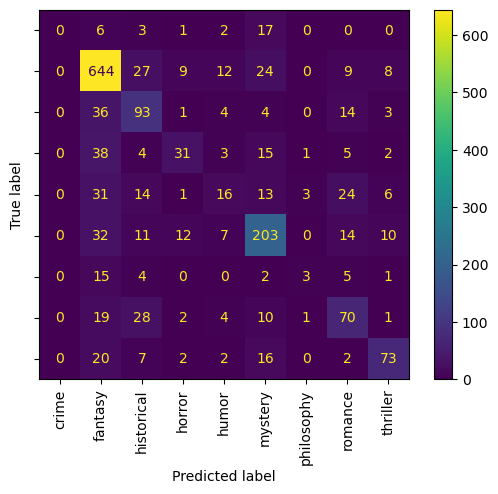

In [80]:
all_preds = conv_model.predict(X_test_vec)
preds = [x.argmax() for x in all_preds]
cm = confusion_matrix(y_test.squeeze(), preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=map(get_class_names,np.sort(y_test.unique())))
disp.plot()
plt.xticks(rotation=90)

In [92]:
type(y_test.tolist())

list

In [95]:
probs = conv_model.predict(X_test_vec)
roc_auc_score(y_test.tolist(), probs, multi_class = 'ovr')

0.8814152143825064

In [ ]:

from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)


#### New Data Prediction

In [170]:
bookSummary = "With its ensemble of warm and unforgettable characters, The Faculty Lounge shows readers a different side of school life. It all starts when an elderly substitute teacher at Baldwin High School is found dead in the faculty lounge. After a bit of a stir, life quickly returns to normal—it’s not like it’s the worst (or even most interesting) thing that has happened within the building’s walls. But when, a week later, the spontaneous scattering of his ashes on the school grounds catches the attention of some busybody parents, it sets in motion a year that can only be described as wild, bizarre, tragic, mundane, beautiful, and humorous all at once.In the midst of the ensuing hysteria and threats of disciplinary action, the novel peeks into the lives of the implicated adults who, it turns out, actually have first names and continue to exist when the school day is done. We a former punk band front man, now a middle-aged principal who must battle it out with the schoolboard to keep his job; a no-nonsense school nurse willing to break the rules, despite the close watch on their campus, when a student arrives at her office with a dilemma; and a disgruntled English instructor who finds himself embroiled in even more controversy when he misfires a snarky email. Oh, and there’s also a teacher make-out session in a supply closet during a lockdown.As these people continue to manage the messiness of this school year, there is the looming threat of what will become of their beloved Baldwin High. Ultimately, at the heart of this unconventional workplace novel is a story of the power of human connection and of the joy of finding purpose in what it is we do every day."
bookTitle = "The Faculty Lounge"
genreNum = 4#humor

In [171]:
def preprocessData(title, summaryText):
    summaryText = title + " " + summaryText
    clean_text = clean_summary(summaryText)
    named_entities = get_named_entities(clean_text)
    clean_text_no_person = removePersonEntities(clean_text, named_entities)
    return (clean_text, clean_text_no_person, named_entities)


(cleanText, cleanTextNoPerson, namedEntities) = preprocessData(bookTitle, bookSummary)

summary = [cleanText]
summary_no_person = [cleanTextNoPerson]
named_entities = [namedEntities]
df = pd.DataFrame({"CleanSummary": summary,"CleanSummaryNoPerson":summary_no_person, "NamedEntities":named_entities, "GenreNum":[genreNum]})
df

,CleanSummary,CleanSummaryNoPerson,NamedEntities,GenreNum
0,Faculty Lounge ensemble warm unforgettable cha...,ensemble warm unforgettable characters sho...,"[(Faculty, PERSON), (Lounge, PERSON), (Faculty...",4


In [172]:
X = df['CleanSummaryNoPerson']
y = df['GenreNum']
X_vec = tfidf_vec.transform(X).toarray()
pred = [x.argmax() for x in conv_model.predict(X_vec)]
print("predicted: " ,get_class_names(pred[0]))
print("actual: " ,get_class_names(y[0]))

predicted:  humor
actual:  humor
